In [144]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn import metrics
from sklearn.utils import shuffle

from sklearn.cluster import DBSCAN

from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as py
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import matplotlib.pyplot as plt

import umap
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

За основу беру DataSet MAGIC Gamma Telescope Data Set https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

In [145]:
df = pd.read_csv("magic04.csv")
df.columns=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

In [146]:
df.loc[df['class'] == 'g', 'class'] = 1
df.loc[df['class'] == 'h', 'class'] = 0
df = shuffle(df) 

Пустых значений нет и это хорошо

In [147]:
#df_temp = df['fM3Trans_abs']
#df_temp =  df.loc[(df['fWidth'] == 0) & (df['class'] == 0), 'fWidth']

#fig = px.scatter(x=df_temp, marginal_x="histogram", 
                 #color=df['class']
#                )
#fig.show()

#fig = px.box(x=df_temp)
#fig.show()

Немного EDA

In [148]:
df['fWidth_null'] = 0; df.loc[df['fWidth'] == 0, 'fWidth_null'] = 1
df['fM3Long_abs']=np.abs(df['fM3Long'])
df['fM3Trans_abs']=np.abs(df['fM3Trans'])

In [149]:
df_y = pd.DataFrame(df['class'])
df_y = df_y.astype('int')
df.drop(['class'], axis='columns', inplace=True)

In [150]:
poly = PolynomialFeatures(degree=3)
real_columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'fM3Long_abs', 'fM3Trans_abs']

df_P_Features = pd.DataFrame(poly.fit_transform(df[real_columns]))
df_P_Features.columns=poly.get_feature_names(real_columns)
df_P_Features.drop(['1']+real_columns, axis='columns', inplace=True)
df = pd.concat([df, df_P_Features], sort=False, axis=1)

Скалируем

In [151]:
pt = PowerTransformer()
pt = StandardScaler()
df_scaled = pd.DataFrame(pt.fit_transform(df))
df_scaled.columns = df.columns

TSNE UMAP отработали не очень хорошо. По этому этот шаг пропускаем.

In [152]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_y, random_state=17)

Посмотрим на Catboost

In [154]:
cat_model = CatBoostClassifier(verbose=False)
cat_model.fit(X_train, y_train)
preds_class = cat_model.predict(X_test)
preds_proba = cat_model.predict_proba(X_test)

In [155]:
print('precision:', metrics.precision_score(y_test, preds_class))
print('recall:', metrics.recall_score(y_test, preds_class))
print('accuracy:', metrics.accuracy_score(y_test, preds_class))
print('F-score:', metrics.f1_score(y_test, preds_class))
print('roc-auc score:', metrics.roc_auc_score(y_test, preds_proba[:, 1]))

precision: 0.8923631990378833
recall: 0.9482428115015974
accuracy: 0.8906414300736067
F-score: 0.919454770755886
roc-auc score: 0.9442776112066845


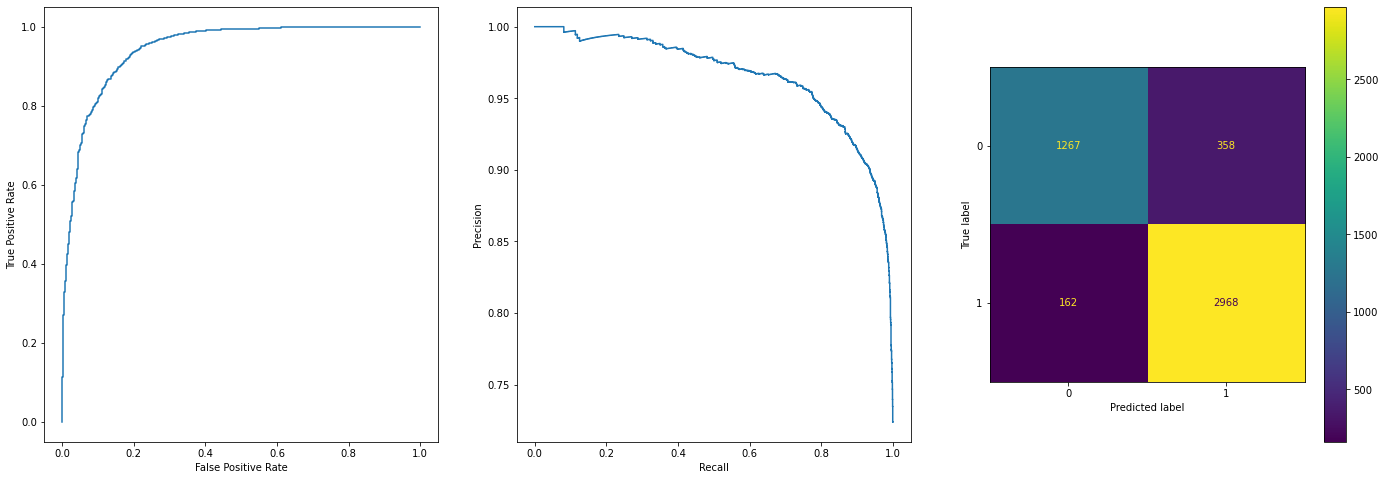

In [156]:
cm = metrics.confusion_matrix(y_test, preds_class)
cm_display = metrics.ConfusionMatrixDisplay(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = metrics.precision_recall_curve(y_test, preds_proba[:, 1])
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
cm_display.plot(ax=ax3)
plt.show()

In [157]:
bst = xgb.XGBClassifier()
bst.fit(X_train, y_train)
preds_class = bst.predict(X_test)
preds_proba = bst.predict_proba(X_test)

C:\Users\QQ\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\QQ\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[20:57:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [158]:
print('precision:', metrics.precision_score(y_test, preds_class))
print('recall:', metrics.recall_score(y_test, preds_class))
print('accuracy:', metrics.accuracy_score(y_test, preds_class))
print('F-score:', metrics.f1_score(y_test, preds_class))
print('roc-auc score:', metrics.roc_auc_score(y_test, preds_proba[:, 1]))

precision: 0.8908869247180737
recall: 0.9338658146964857
accuracy: 0.8811777076761304
F-score: 0.9118702230541257
roc-auc score: 0.9370681739985254


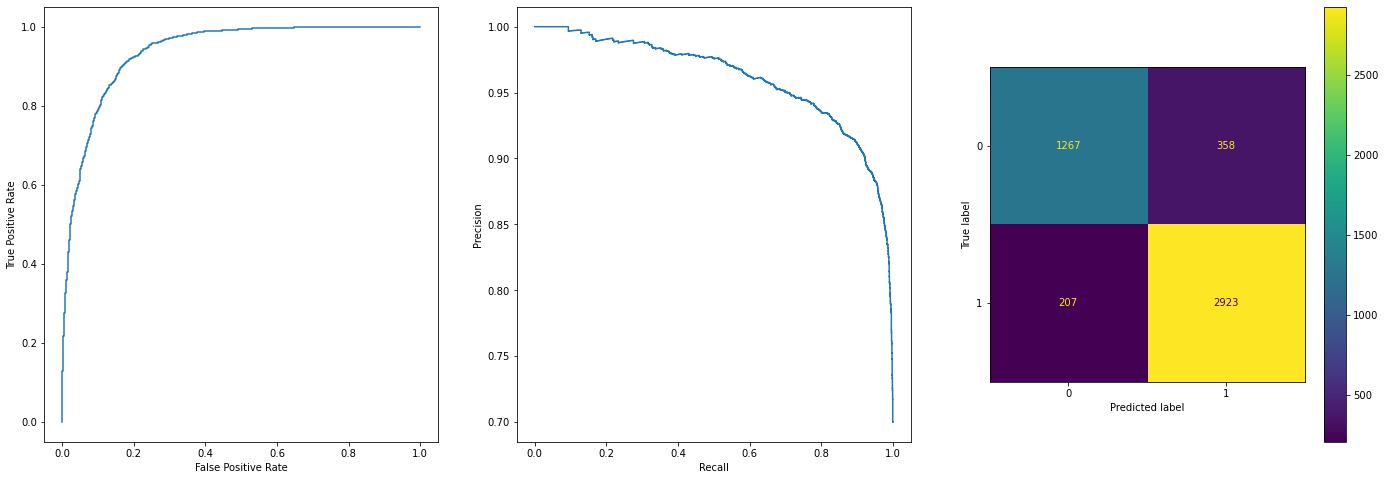

In [159]:
cm = metrics.confusion_matrix(y_test, preds_class)
cm_display = metrics.ConfusionMatrixDisplay(cm)

fpr, tpr, _ = metrics.roc_curve(y_test, preds_proba[:, 1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = metrics.precision_recall_curve(y_test, preds_proba[:, 1])
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
cm_display.plot(ax=ax3)
plt.show()

In [160]:
from sklearn.inspection import permutation_importance
r = permutation_importance(cat_model, X_test, y_test, n_repeats=30, random_state=17)

In [162]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

fSize^2 0.022 +/- 0.002
fLength fWidth fConc0.018 +/- 0.002
fSize^3 0.018 +/- 0.002
fSize^2 fConc0.017 +/- 0.002
fSize^2 fConc10.004 +/- 0.002
fWidth^2 fConc0.003 +/- 0.001
fWidth^2 fConc10.002 +/- 0.001
fWidth fConc0.002 +/- 0.001
fLength fConc0.002 +/- 0.001
fLength^2 fAlpha0.002 +/- 0.001
fLength fConc10.002 +/- 0.001
fWidth^20.002 +/- 0.001
fWidth fSize fConc10.002 +/- 0.001
fWidth^2 fSize0.002 +/- 0.001
fM3Long fAlpha fM3Long_abs0.002 +/- 0.001
fLength^2 fWidth0.002 +/- 0.001
fConc fM3Long_abs0.001 +/- 0.001
fSize fConc fM3Trans_abs0.001 +/- 0.001
fWidth^2 fAlpha0.001 +/- 0.001
fConc1 fAlpha0.001 +/- 0.000
fLength fConc fConc10.001 +/- 0.000
fWidth fConc fM3Trans0.001 +/- 0.000
fDist^2 fM3Trans_abs0.001 +/- 0.000
fConc fConc1 fM3Long_abs0.001 +/- 0.000
fM3Trans fDist fM3Trans_abs0.001 +/- 0.000
fM3Long fM3Trans^20.001 +/- 0.000
fLength fM3Long0.001 +/- 0.000
fWidth fSize fM3Long_abs0.001 +/- 0.000
fAsym fAlpha0.001 +/- 0.000
fM3Trans fAlpha fM3Long_abs0.001 +/- 0.000
fConc1 fM3Tra

In [164]:
import shap

shap_test = shap.TreeExplainer(cat_model).shap_values(X_test)
shap.summary_plot(shap_test, X_test, max_display=25, auto_size_plot=True)

ModuleNotFoundError: No module named 'shap'